<Strong> Note to the reader: </Strong> This notebook currently calculates the cross correlation of the PanSTARRS SuperNova set with the LOWZ and CMASS galaxy catalogs from eBOSS (SDSS). There are also some trouble shooting/data validation calculations along the way. </br>

Annotations about TreeCorr are taken from the documentation and all credit goes to Mike Jarvis. </br>

https://rmjarvis.github.io/TreeCorr/_build/html/overview.html </br>

-MT 6/11/20

#### List of changes/fixes that are not resolved: 

- Data for panstarrs is outside the pointing? --- NEED TO INVESTIGATE 
- Corr func asymptotes to .2 instead of zero? --- NEED TO DO 
- Theory calculuation --- NEED TO SWITCH TO DOING 
- Better way to populate the randoms into the mask? Apply the mask over top? --- FIX ME (Eventually)

### Imports and formatting: 

In [1]:
# Make Jupyter Notebook full screen 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.display import Image

In [2]:
#plt.switch_backend('agg') #For HEP, matplotlib x windows issues see python version for more usage 
import treecorr
import numpy
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import os
import datetime

### Define notebook wide functions and data paths to use:

In [3]:
dataPath = '/Users/megantabbutt/CosmologyDataProducts/'
#dataPath = '/afs/hep.wisc.edu/home/tabbutt/private/CosmologyDataProducts/'

testingProductsPath = "/Users/megantabbutt/Cosmology/Cosmology/SNe CrossCorrelations/VerificationTestingProducts/"

# Python has datename, savfig folder fields, usually don't save this code just for monkeying around... 
# If wanted to save some plots, should invoke this, and add text file to the folder with notes for that run 

date = ' 05_29_20_12pm'

In [4]:
# Define the paths for local and HEP machines:
DATA_PATH = '/Users/megantabbutt/CosmologyDataProducts/'
#DATA_PATH = '/afs/hep.wisc.edu/home/tabbutt/private/CosmologyDataProducts/'

TESTING_PRODUCTS_PATH = "/Users/megantabbutt/Cosmology/Cosmology/SNe CrossCorrelations/VerificationTestingProducts/"
#TESTING_PRODUCTS_PATH = "/afs/hep.wisc.edu/home/tabbutt/public/Cosmology/SNe CrossCorrelations/VerificationTestingProducts/"

# Create the directory to save to and a file with info about this run:
DATE = datetime.datetime.now().strftime("%d_%m_%Y_%H_%M")
CURRENT_DIRECTORY = DATE
TESTING_PRODUCTS_PATH = TESTING_PRODUCTS_PATH + CURRENT_DIRECTORY

os.mkdir(TESTING_PRODUCTS_PATH)

NOTES_NAME = "/RUNNING_NOTES_" + DATE + ".txt"
NOTES_PATH = TESTING_PRODUCTS_PATH + NOTES_NAME

### Start writing notes to textfile:
Write notes about:
- Steps completed in program
- plot made and saved to folder
- Amount of data points, randoms points in plots and data runs

In [5]:
# Write an opening note in the file:
NOTES = open(NOTES_PATH, "a")
NOTES.write("Created Running notes file for tracking details about this run and products produced/saved")
NOTES.write("\n \n")
NOTES.close()

 <hr style="height:3px"> 


## 0. Pull in and parse data:

note: There are 10 pointings for the PanSTARRS data, we will use all 10 for the Auto Correlation, but when we correlated to CMASS, we need to only use the 9 overlap with CMASS. --- IMPORTANT

In [6]:
NOTES = open(NOTES_PATH, "a")
NOTES.write("0. Pull in and parse data:")
NOTES.write("\n \n")
NOTES.close()

#### PanSTARRS: 

In [7]:
connBOSS = sqlite3.connect(dataPath + 'CMASS_and_LOWZ.db')

qry = "SELECT * FROM CMASSLOWZTOT_South"

CMASSLOWZTOT_DF = pd.read_sql(qry, con=connBOSS)
CMASSLOWZTOT_DF.head(3) # 1.3 million objects

,index,RA,DEC,Z,NZ
0,0,321.480329,9.973440,0.301401,0.000390
1,1,321.359691,9.933358,0.458872,0.000350
2,2,322.614181,10.144496,0.579383,0.000273


In [8]:
NOTES = open(NOTES_PATH, "a")
NOTES.write("CMASSLOWZTOT_DF Database objects: " + str(len(CMASSLOWZTOT_DF)))
NOTES.write("\n \n")
NOTES.close()
connBOSS.close()

#### Pull in the Randoms provided by CMASS:

In [9]:
connBOSSRands = sqlite3.connect(dataPath + 'CMASS_and_LOWZ_rands.db')
randSampleQry = "SELECT * FROM CMASSLOWZTOT_South_rands"
#randQry = "SELECT * FROM CMASSLOWZTOT_South_rands UNION SELECT * FROM CMASSLOWZTOT_North_rands"

CMASSLOWZTOT_DF_rands = pd.read_sql(randSampleQry, con=connBOSSRands)
CMASSLOWZTOT_DF_rands.to_json(dataPath + "CMASSLOWZTOT_DF_rands")
CMASSLOWZTOT_DF_rands.head(3)

,index,RA,DEC,Z,NZ
0,0,332.902777,-3.099005,0.485921,0.000416
1,1,3.395979,0.256192,0.449228,0.000311
2,2,349.358564,24.769733,0.474374,0.000378


In [10]:
connBOSSRands.close()

 <hr style="height:3px"> 

## 4. Make CMASS Count-Count Auto Correlation Functions:

Typical Usage Pattern:

> nn = treecorr.NNCorrelation(config) 
<br>
nn.process(cat)     # For auto-correlation.
<br>
nn.process(cat1,cat2)   # For cross-correlation.
<br>
rr.process...           # Likewise for random-random correlations
<br>
dr.process...        # If desired, also do data-random correlations
<br>
rd.process...    # For cross-correlations, also do the reverse.
<br>
nn.write(file_name,rr,dr,rd)  # Write out to a file.
<br>
xi,varxi = nn.calculateXi(rr,dr,rd)  # Or get the correlation function directly.

In [11]:
NOTES = open(NOTES_PATH, "a")
NOTES.write("4. Make CMASS Count-Count Auto Correlation Functions:")
NOTES.write("\n \n")
NOTES.close()

In [12]:
cat_eBOSS = treecorr.Catalog(ra=CMASSLOWZTOT_DF['RA'], dec=CMASSLOWZTOT_DF['DEC'], ra_units='degrees', dec_units='degrees')
cat_eBOSS


Catalog(x=array([0.77057095, 0.76937222, 0.78214325, ..., 0.84865677, 0.8629375 ,
       0.86439047]),y=array([-0.61337188, -0.61506848, -0.59768698, ..., -0.52849314,
       -0.50483339, -0.50234678]),z=array([0.17319164, 0.17250261, 0.17613125, ..., 0.0218331 , 0.02195715,
       0.02183655]),ra=array([5.61089021, 5.6087847 , 5.63067967, ..., 5.72621229, 5.75385533,
       5.75673601]),dec=array([0.17406936, 0.1733698 , 0.17705486, ..., 0.02183483, 0.02195891,
       0.02183828]),w=array([1., 1., 1., ..., 1., 1., 1.]))

In [13]:
NOTES = open(NOTES_PATH, "a")
NOTES.write("Created cat_eBOSS.")
NOTES.write("\n \n")
NOTES.close()

In [14]:
nn_eBOSS_Auto_self = treecorr.NNCorrelation(min_sep=0.01, max_sep=10, bin_size=0.2, sep_units='degrees')
nn_eBOSS_Auto_self.process(cat_eBOSS)

cat_rand_eBOSS = treecorr.Catalog(ra=CMASSLOWZTOT_DF_rands['RA'], dec=CMASSLOWZTOT_DF_rands['DEC'], ra_units='degrees', dec_units='degrees')
rr_eBOSS = treecorr.NNCorrelation(min_sep=0.01, max_sep=10, bin_size=0.2, sep_units='degrees')
rr_eBOSS.process(cat_rand_eBOSS)

dr_eBOSS = treecorr.NNCorrelation(min_sep=0.01, max_sep=10, bin_size=0.2, sep_units='degrees')
dr_eBOSS.process(cat_eBOSS, cat_rand_eBOSS)

r_eBOSS = numpy.exp(nn_eBOSS_Auto_self.meanlogr)
xi_eBOSS, varxi_eBOSS = nn_eBOSS_Auto_self.calculateXi(rr_eBOSS, dr_eBOSS)
sig_eBOSS = numpy.sqrt(varxi_eBOSS)

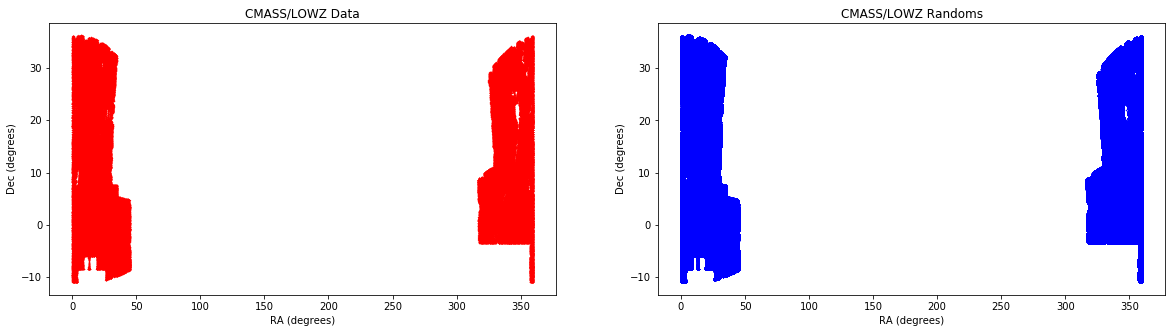

In [15]:
f3, (ax1c, ax2c) = plt.subplots(1, 2, figsize=(20, 5))

ax1c.scatter(cat_eBOSS.ra * 180/numpy.pi, cat_eBOSS.dec * 180/numpy.pi, color='red', s=0.1)
ax1c.set_xlabel('RA (degrees)')
ax1c.set_ylabel('Dec (degrees)')
ax1c.set_title('CMASS/LOWZ Data')

# Repeat in the opposite order
ax2c.scatter(CMASSLOWZTOT_DF_rands['RA'], CMASSLOWZTOT_DF_rands['DEC'], color='blue', s=0.1)
ax2c.set_xlabel('RA (degrees)')
ax2c.set_ylabel('Dec (degrees)')
ax2c.set_title('CMASS/LOWZ Randoms')

plt.savefig(TESTING_PRODUCTS_PATH + "/CMASS_LOWZ Randoms")
plt.show()

In [16]:
NOTES = open(NOTES_PATH, "a")
NOTES.write("Plotted: CMASS_LOWZ Randoms")
NOTES.write("\n \n")
NOTES.close()

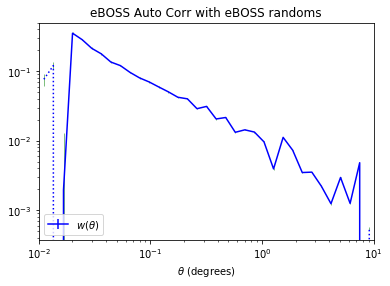

In [17]:
# Plot the autocorrelation function:

plt.plot(r_eBOSS, xi_eBOSS, color='blue')
plt.plot(r_eBOSS, -xi_eBOSS, color='blue', ls=':')
plt.errorbar(r_eBOSS[xi_eBOSS>0], xi_eBOSS[xi_eBOSS>0], yerr=sig_eBOSS[xi_eBOSS>0], color='green', lw=0.5, ls='')
plt.errorbar(r_eBOSS[xi_eBOSS<0], -xi_eBOSS[xi_eBOSS<0], yerr=sig_eBOSS[xi_eBOSS<0], color='green', lw=0.5, ls='')
leg = plt.errorbar(-r_eBOSS, xi_eBOSS, yerr=sig_eBOSS, color='blue')
plt.xscale('log')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (degrees)')
plt.legend([leg], [r'$w(\theta)$'], loc='lower left')
plt.xlim([0.01,10])
plt.title("eBOSS Auto Corr with eBOSS randoms")

plt.savefig(TESTING_PRODUCTS_PATH + "/eBOSS Auto Corr with eBOSS randoms")
plt.show()